In [1]:

!pip install -q star-privateer lightkurve==2.4.2 george tqdm pathos --break-system-packages

# 2. IMPORTS
import lightkurve as lk
import star_privateer as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.stats import sigma_clip
from scipy.signal import detrend
import astropy.units as u

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.6/395.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 39.3 MB/s eta 0:00:00
  

In [26]:
tic = "167814656"
sectors = [6, 12, 67, 68, 69]

print("Clearing cache and downloading sectors:", sectors)
!rm -rf /root/.lightkurve/cache

lcf = lk.search_lightcurve(f"TIC {tic}", author="SPOC", exptime=120, sector=sectors)
print(f"Found {len(lcf)} light curve files")

# Download and stitch
lc_list = lcf.download_all()
if not lc_list:
    raise ValueError("No data found – something wrong with TIC or sectors")

lc = lc_list[0].remove_nans().normalize()
for extra in lc_list[1:]:
    lc = lc.append(extra.remove_nans().normalize())

lc = lc.remove_outliers(sigma=4)
t, f = lc.time.value, lc.flux

print(f"Success! Stitched LC: {len(t):,} points, {t[-1]-t[0]:.1f} days baseline")

Clearing cache and downloading sectors: [6, 12, 67, 68, 69]
Found 5 light curve files
Success! Stitched LC: 76,173 points, 1737.8 days baseline


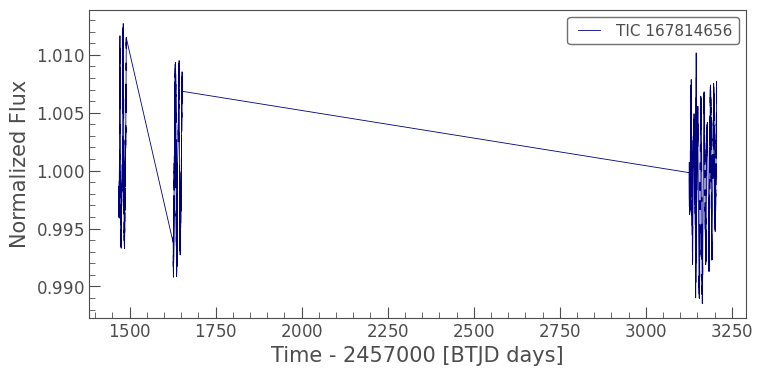

In [25]:
# Quick plot
lc.plot(lw=0.6, color='navy', title=f"HIP 33690 – Sectors {sectors}")
plt.savefig("HIP33690_full_LC.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 900x400 with 0 Axes>

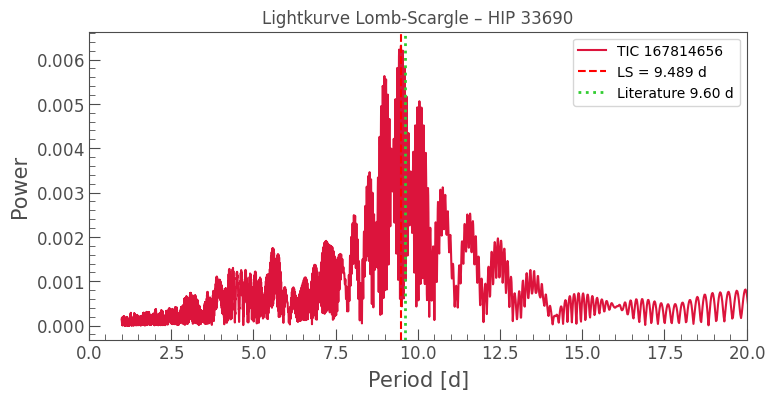

In [4]:
# 4. Lightkurve Lomb-Scargle
pg = lc.to_periodogram(method='lombscargle', minimum_period=1*u.day, maximum_period=30*u.day, oversample_factor=10)
ls_period = pg.period_at_max_power.value

plt.figure(figsize=(9,4))
pg.plot(color='crimson', lw=1.5)
plt.axvline(ls_period, color='red', ls='--', label=f'LS = {ls_period:.3f} d')
plt.axvline(9.6, color='limegreen', lw=2, ls=':', label='Literature 9.60 d')
plt.xlim(0, 20)
plt.title("Lightkurve Lomb-Scargle – HIP 33690")
plt.legend()
plt.savefig("HIP33690_LS.png", dpi=300)
plt.show()

In [5]:
# 5. Pre-process for Star-Privateer
f_values_raw = f.value
if isinstance(f_values_raw, np.ma.MaskedArray):
    f_values = f_values_raw.filled(np.nan).astype(float)
else:
    # Ensure it's a plain NumPy array and float type
    f_values = f_values_raw.astype(float)

# sigma_clip to the standard NumPy array, returning a plain array with NaNs
f_clean_interim = sigma_clip(f_values, sigma=4, maxiters=5, masked=False)
f_clean = np.asarray(f_clean_interim)
f_clean = np.nan_to_num(f_clean, nan=np.nanmedian(f_clean))
f_clean = detrend(f_clean)
f_clean = (f_clean - f_clean.mean()) / f_clean.std()

# 4-hour rebinning
bin_h = 4
t_bin, f_bin = sp.rebin(t, bin_h), sp.rebin(f_clean, bin_h)
dt = bin_h * 3600

print(f"After 4h rebinning: {len(t_bin)} points")

After 4h rebinning: 19043 points


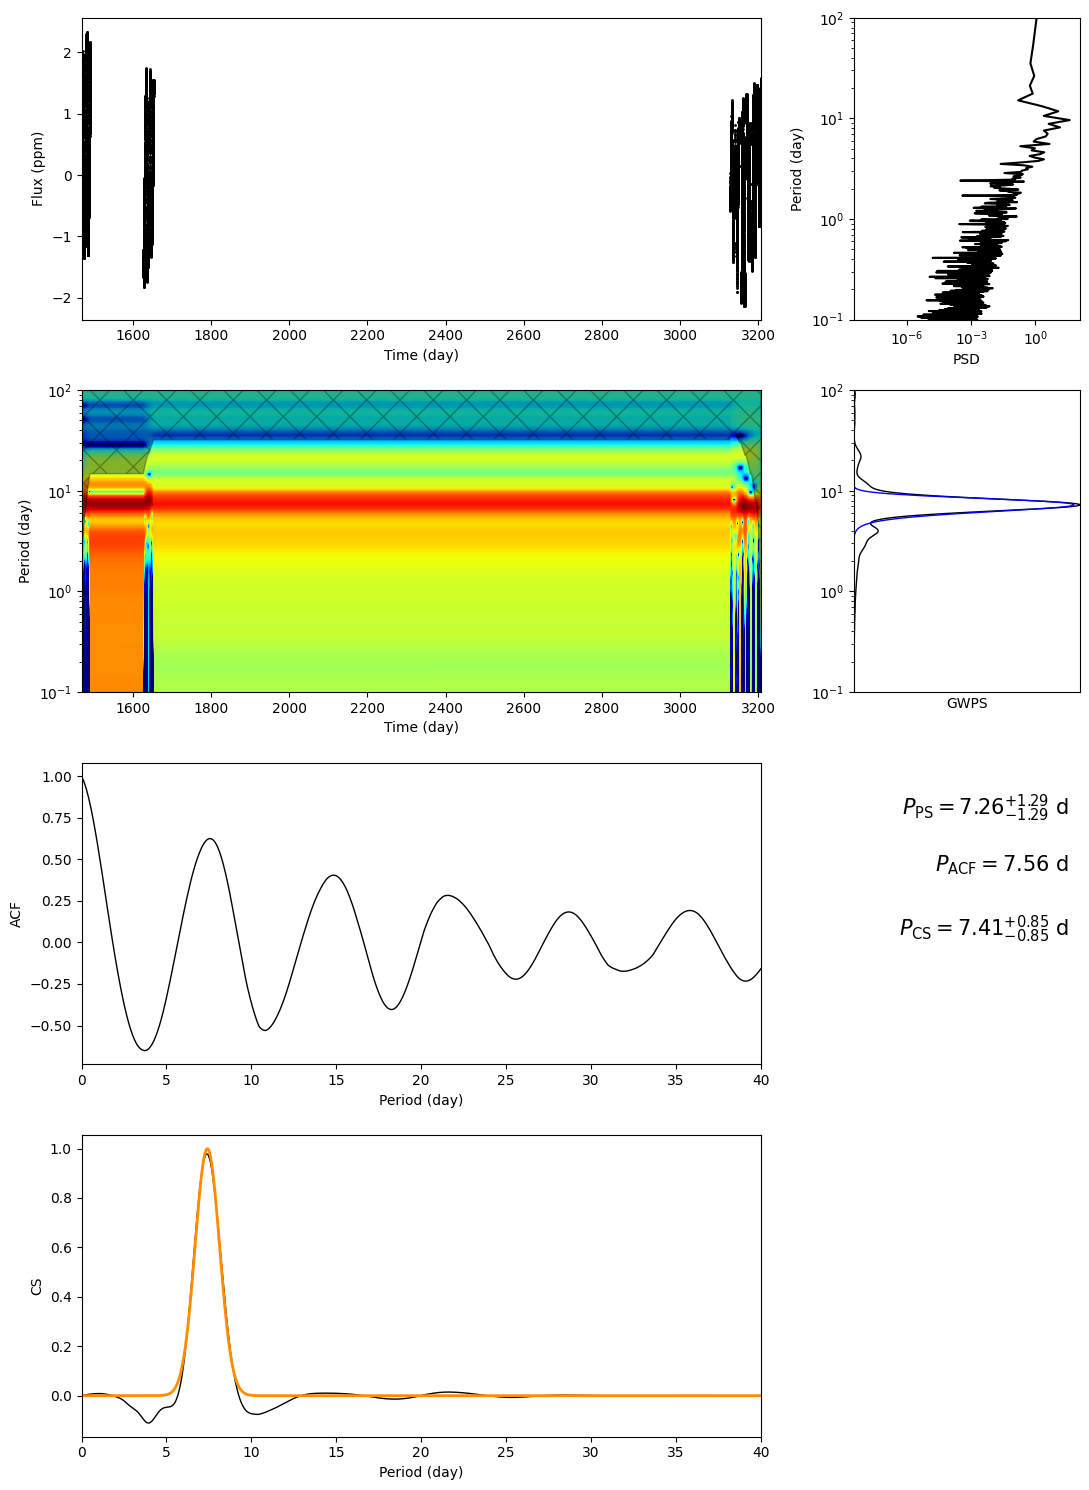

In [6]:
os.makedirs("HIP33690_results", exist_ok=True)

(p_wps, p_acf, gwps, wps, acf, cs, coi, features, feature_names, fig) = sp.analysis_pipeline(
    t_bin, f_bin,
    figsize=(11,15), plot=True, xlim=(0,40),
    normscale='log', ylogscale=True,
    add_periodogram=True, wavelet_analysis=True
)

plt.savefig("HIP33690_results/ROOSTER_full.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
periods, _, gwps_full, _, _ = sp.compute_wps(f_bin, dt, normalise=True)
prot_gauss, err_gauss, _ = sp.compute_prot_err_gaussian_fit(periods, gwps_full, n_profile=5)

print(f"Rotation period from Gaussian fit: {prot_gauss:.3f} +/- {err_gauss:.3f} days")

Rotation period from Gaussian fit: 217.765 +/- 38.567 days


<Figure size 1000x500 with 0 Axes>

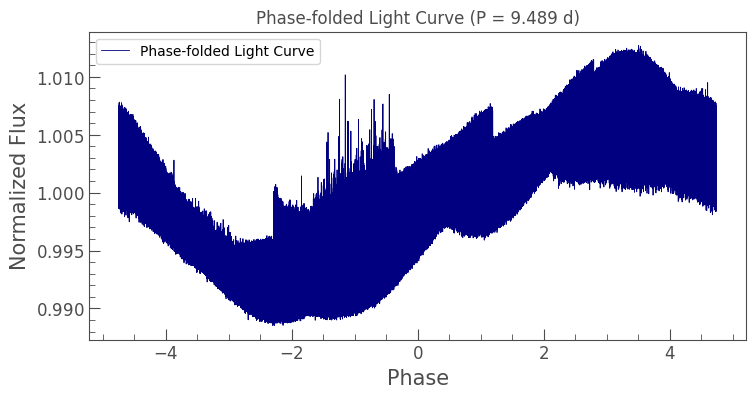

Phase-folded light curve plotted and saved.


In [9]:
folded_lc = lc.fold(period=ls_period)

plt.figure(figsize=(10, 5))
folded_lc.plot(lw=0.6, color='navy', label='Phase-folded Light Curve')
plt.title(f'Phase-folded Light Curve (P = {ls_period:.3f} d)')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.legend()
plt.savefig("HIP33690_phase_folded_LC.png", dpi=300, bbox_inches='tight')
plt.show()
print("Phase-folded light curve plotted and saved.")

<Figure size 1000x500 with 0 Axes>

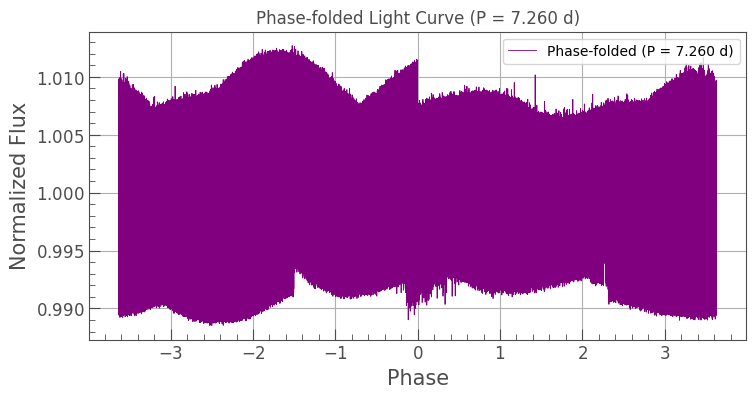

In [22]:
from cupy import testing
testing_period = 7.26
folded_lc_custom = lc.fold(period=testing_period)
plt.figure(figsize=(10, 5))
folded_lc_custom.plot(lw=0.6, color='purple', label=f'Phase-folded (P = {testing_period:.3f} d)')
plt.title(f'Phase-folded Light Curve (P = {testing_period:.3f} d)')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.legend()
plt.grid(True)
plt.savefig(f"HIP33690_phase_folded_LC_P_{testing_period:.3f}d.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x500 with 0 Axes>

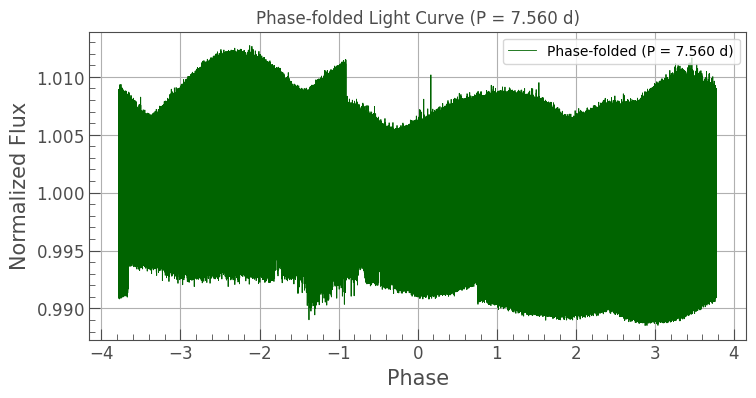

Phase-folded light curve for P = 7.560 days plotted and saved.


In [19]:
from cupy import testing
testing_period = 7.56
folded_lc_custom = lc.fold(period=testing_period)
plt.figure(figsize=(10, 5))
folded_lc_custom.plot(lw=0.6, color='darkgreen', label=f'Phase-folded (P = {testing_period:.3f} d)')
plt.title(f'Phase-folded Light Curve (P = {testing_period:.3f} d)')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.legend()
plt.grid(True)
plt.savefig(f"HIP33690_phase_folded_LC_P_{testing_period:.3f}d.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Phase-folded light curve for P = {testing_period:.3f} days plotted and saved.")

<Figure size 1000x500 with 0 Axes>

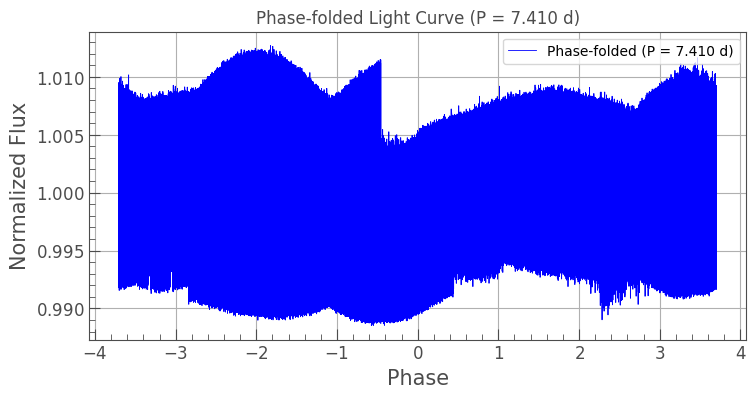

In [23]:
from cupy import testing
testing_period = 7.41
folded_lc_custom = lc.fold(period=testing_period)
plt.figure(figsize=(10, 5))
folded_lc_custom.plot(lw=0.6, color='blue', label=f'Phase-folded (P = {testing_period:.3f} d)')
plt.title(f'Phase-folded Light Curve (P = {testing_period:.3f} d)')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.legend()
plt.grid(True)
plt.savefig(f"HIP33690_phase_folded_LC_P_{testing_period:.3f}d.png", dpi=300, bbox_inches='tight')
plt.show()